In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import itertools
import os

### Process Data for Travel Zones

Reference: [Can I get exact coordinates of London zones and use them in code?](https://stackoverflow.com/questions/45247439/can-i-get-exact-coordinates-of-london-zones-and-use-them-in-code)

```python
import zipfile

# Define file paths
kmz_file = "../data/external/London Transport Zone Map.kmz"
output_dir = "../data/external"

# Extract the KMZ file
with zipfile.ZipFile(kmz_file, 'r') as kmz:
    kmz.extractall(output_dir)


# Load Data 

In [3]:
df = pd.read_parquet("../data/processed/rent_london.parquet") # Apify data after EDA1
london_boundaries = gpd.read_file('../data/external/london_boroughs.geojson') # Downloaded from https://github.com/radoi90/housequest-data
london_stations = gpd.read_file("../data/external/london_stations.geojson")

output_dir = "../data/external"
kml_file = os.path.join(output_dir, 'doc.kml')
zone_fares = gpd.read_file(kml_file) #Load travel zones geometry
road_noize = gpd.read_file("../data/external/Road_LAeq_16h_London/Road_LAeq_16h_London.shp")# https://data.london.gov.uk/dataset/noise-pollution-in-london

Skipping field lines: unsupported OGR type: 5
/home/zcemg08/projects/AIRFLOW_DATA_PROPERTIES/.rent_env/lib/python3.10/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'doc.kml': 'Zones' (default), 'Zone 3 & 4 Stations', 'Zone 4 Stations', 'Zone 5 Stations', 'Zone 5 & 6 Stations', 'Zone 6 Stations', 'Zone 6 & 7 Stations', 'Zone 7 Stations', 'Zone 8 Stations', 'Zone 9 Stations'. Specify layer parameter to avoid this warning.
  result = read_func(


Merge external data with scrapped rental data

In [4]:
# Convert Pandas DataFrame to GeoPandas for spatial manipulation of the data
df["geometry"] = df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs(epsg=4326, inplace=True) 

# Merge spatialy with boroughs
gdf = gpd.sjoin(gdf, london_boundaries, how="left")
gdf = gdf.rename(columns={"name":"borough"})
gdf = gdf.drop("index_right",axis=1)

#Merge spatialy travel zones to properties
gdf = gpd.sjoin(gdf, zone_fares, how="left")
gdf = gdf.rename(columns={"Name":"zone"})
gdf = gdf.drop(columns=["index_right","Description"])

# only 21 places were NaNs
gdf = gdf[gdf["zone"].notna()]
gdf["zone"] = gdf["zone"].apply(lambda x: x.split(" ")[-1]) # remove zone word

# change road noize poligon coordinates to latitude and longitude
road_noize = road_noize.set_crs(epsg=27700, allow_override=True)
road_noize = road_noize.to_crs(epsg=4326)

In [5]:
gdf.shape

(30055, 39)

In [6]:
gdf.head(2)

,title,displayAddress,outcode,incode,bathrooms,bedrooms,propertyType,price,secondaryPrice,letAvailableDate,...,distance_to_station1,distance_to_station2,distance_to_station3,station_type1,station_type2,station_type3,geometry,borough,color,zone
id,,,,,,,,,,,,,,,,,,,,,
154825190,"3 bedroom house for rent in Novello Street, Pa...","Novello Street, Parsons Green, London, SW6",SW6,4JB,2.0,3.0,House,18633,4300,Ask agent,...,0.086670,0.375000,0.713867,[LONDON_UNDERGROUND],[LONDON_UNDERGROUND],[NATIONAL_TRAIN],POINT (-0.19944 51.47583),Hammersmith and Fulham,blue,2
155893427,"4 bedroom house for rent in Studdridge Street,...","Studdridge Street, Fulham, London, SW6",SW6,3SL,4.0,4.0,House,13000,3000,Ask agent,...,0.400879,0.496338,0.583984,[LONDON_UNDERGROUND],[NATIONAL_TRAIN],[LONDON_UNDERGROUND],POINT (-0.19348 51.4721),Hammersmith and Fulham,blue,2


In [13]:
road_noize["center"] = road_noize["geometry"].centroid
road_noize = road_noize.set_geometry("center")
gdf = gpd.sjoin_nearest(gdf,road_noize,"left",max_distance=200)

/tmp/ipykernel_24122/2747400482.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  road_noize["center"] = road_noize["geometry"].centroid
/home/zcemg08/projects/AIRFLOW_DATA_PROPERTIES/.rent_env/lib/python3.10/site-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [6]:
gdf.columns

Index(['title', 'displayAddress', 'outcode', 'incode', 'bathrooms', 'bedrooms',
       'propertyType', 'price', 'secondaryPrice', 'letAvailableDate',
       'deposit', 'letType', 'furnishType', 'councilTaxExempt',
       'councilTaxIncluded', 'councilTaxBand', 'description', 'features',
       'listingUpdateReason', 'listingUpdateDate', 'firstVisibleDate',
       'addedOn', 'sizeSqFeetMin', 'sizeSqFeetMax', 'latitude', 'longitude',
       'station_name1', 'station_name2', 'station_name3',
       'distance_to_station1', 'distance_to_station2', 'distance_to_station3',
       'station_type1', 'station_type2', 'station_type3', 'geometry',
       'borough', 'color', 'zone'],
      dtype='object')

In [7]:
# Quick overview over float variables 

gdf.describe()

,bathrooms,bedrooms,price,secondaryPrice,sizeSqFeetMin,sizeSqFeetMax,latitude,longitude,distance_to_station1,distance_to_station2,distance_to_station3
count,30055.000000,28744.000000,30055.000000,30055.000000,30055.000000,30055.000000,30055.000000,30055.000000,30055.000000,30055.000000,30054.000000
mean,1.585992,2.188109,4057.335252,936.319514,388.500116,388.598869,51.506639,-0.141061,0.338379,0.555176,0.707520
std,1.102933,1.193721,6146.962478,1418.526990,964.292181,964.343666,0.053869,0.113461,0.916504,0.927734,0.735840
min,1.000000,1.000000,400.000000,92.000000,0.000000,0.000000,51.299250,-0.488402,0.000000,0.006222,0.038788
25%,1.000000,1.000000,1950.000000,450.000000,0.000000,0.000000,51.481420,-0.195924,0.165283,0.338623,0.458496
50%,1.000000,2.000000,2700.000000,623.000000,0.000000,0.000000,51.507900,-0.149391,0.269775,0.478027,0.619629
75%,2.000000,3.000000,4117.000000,950.000000,651.000000,652.000000,51.537718,-0.072721,0.421631,0.663574,0.839844
max,111.000000,60.000000,216667.000000,50000.000000,66004.000000,66004.000000,51.683330,0.267228,106.500000,107.062500,106.062500


1. Some dodgy numbers for the distances in miles to 3 nearest stations , bathrooms, bedrooms
2. Rent price of the 25th percentile is close to my previos job salary after tax ... 😔

Text(0, 0.5, 'Fraction')

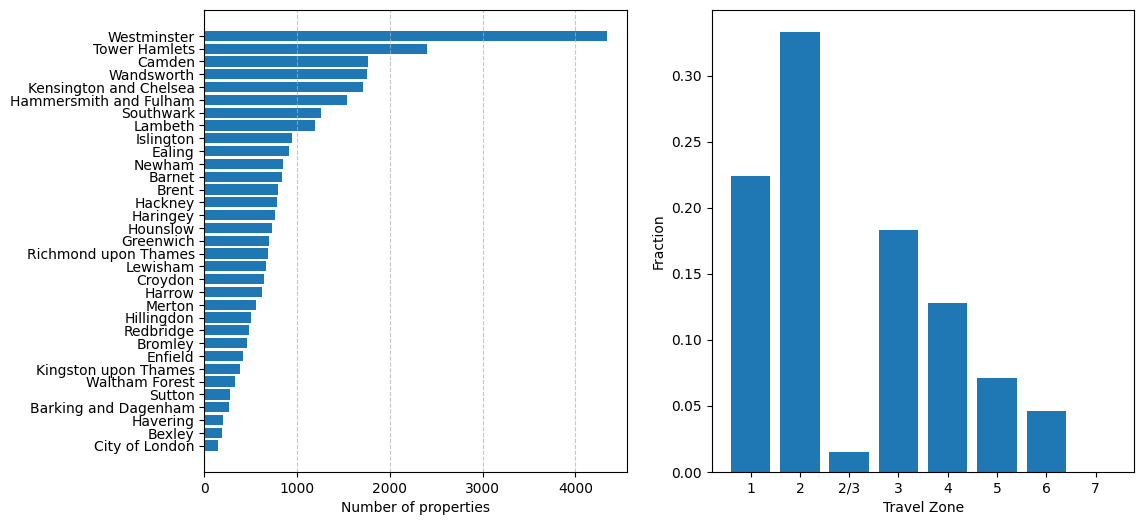

In [8]:
zone_demand = gdf.groupby("zone").agg("count")["title"].reset_index().rename({"title":"count"},axis=1)
zone_demand["count"] = zone_demand["count"]/len(gdf)
boroughs_demand = gdf.groupby("borough").agg("count")["title"].reset_index().rename({"title":"count"},axis=1).sort_values(by="count",ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes = axes.flatten()

axes[0].barh(boroughs_demand["borough"], boroughs_demand["count"])
axes[0].grid(True, axis='x', linestyle='--', alpha=0.7)
axes[0].set_xlabel("Number of properties")

axes[1].bar(zone_demand["zone"], zone_demand["count"])
axes[1].set_xlabel('Travel Zone')
axes[1].set_ylabel('Fraction')


In [9]:
(gdf["bedrooms"]>8).sum(), (gdf["bathrooms"]>6).sum() # outliers in bedrooms, bathrooms

(11, 61)

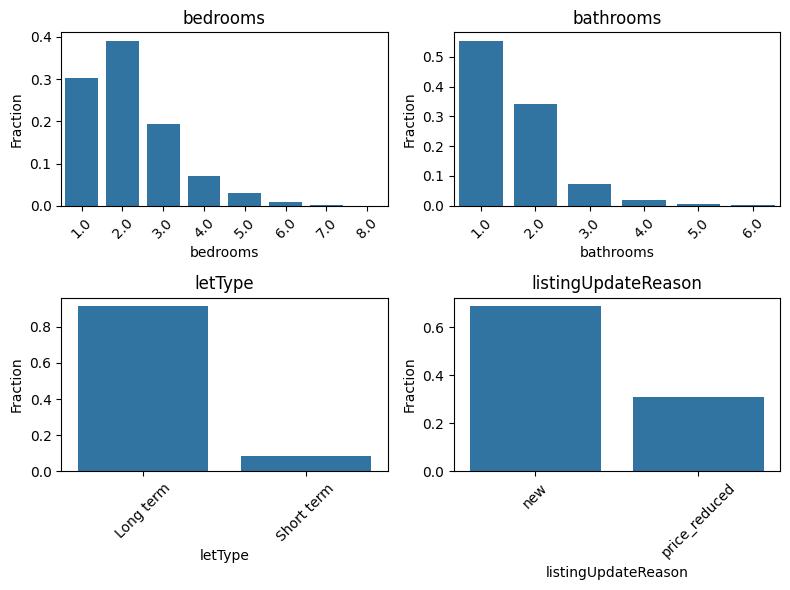

In [10]:
# Types of housing and contracts

gdf = gdf[(gdf["bedrooms"]<=8) & (gdf["bathrooms"]<=6)] # remove above outliers

categorical_features = ['bedrooms', 'bathrooms', 'letType', 'listingUpdateReason']

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for i, column in enumerate(categorical_features):
    value_counts = gdf[column].value_counts(normalize=True).reset_index()
    value_counts.columns = [column, 'fraction']
    sns.barplot(data=value_counts, x=column, y='fraction', ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Fraction')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [11]:
"Properies that specify deposit = {} %".format(round((gdf["deposit"]==True).sum()/len(gdf)*100))

'Properies that specify deposit = 74 %'

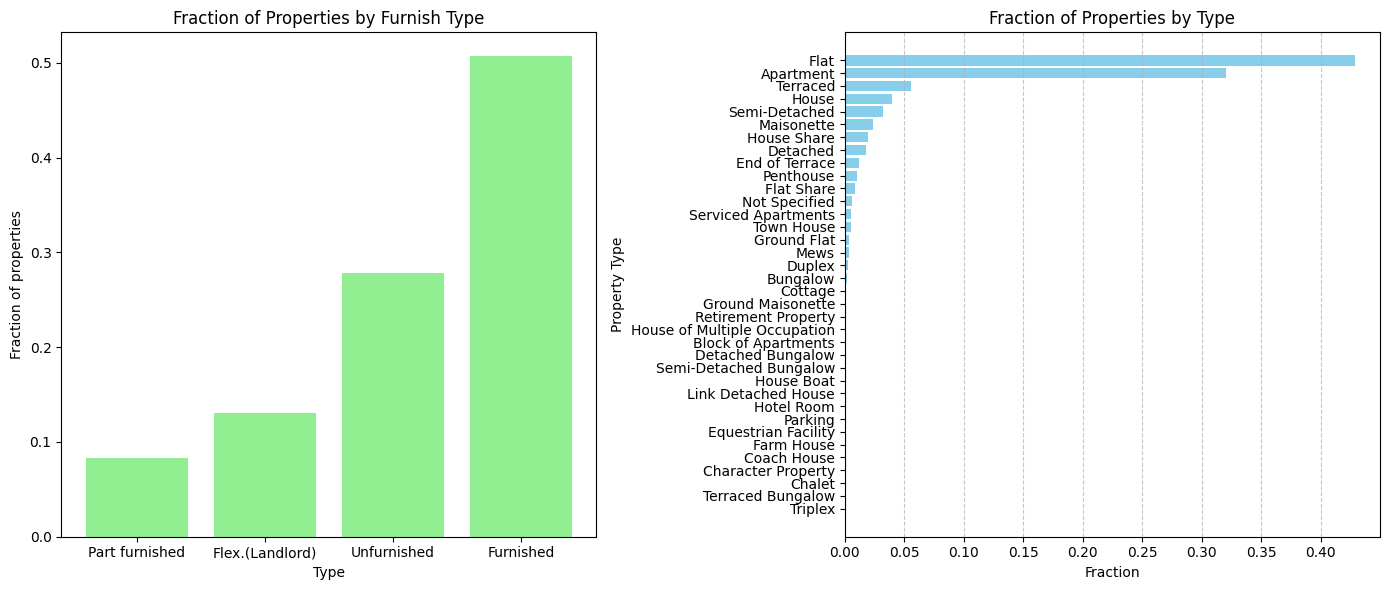

In [12]:
# Where people live

furnish = gdf[gdf["furnishType"].notna()].groupby("furnishType").agg("count")["title"].reset_index().rename({"title":"count"},axis=1)
furnish = furnish.sort_values("count",ascending=True)
furnish.loc[1, "furnishType"] = "Flex.(Landlord)"
furnish["furnish_normilized"] = furnish["count"]/len(gdf[gdf["furnishType"].notna()])

prop_types = gdf.groupby("propertyType").agg("count")["title"].reset_index().rename({"title":"count"},axis=1)
prop_types = prop_types.sort_values(by="count",ascending=True)
prop_types["count_normilized"] = prop_types["count"]/len(gdf)


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for furnishing types
axes[0].bar(furnish["furnishType"], furnish["furnish_normilized"], color='lightgreen')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Fraction of properties')
axes[0].set_title('Fraction of Properties by Furnish Type')


# Plot for property types
axes[1].barh(prop_types["propertyType"], prop_types["count_normilized"], color='skyblue')
axes[1].set_xlabel('Fraction')
axes[1].set_ylabel('Property Type')
axes[1].grid(True, axis='x', linestyle='--', alpha=0.7)
axes[1].set_title('Fraction of Properties by Type')

plt.tight_layout()
plt.show()

#### Transport Access

In [14]:
"""fig, axes = plt.subplots(1, 2, figsize=(5, 3))

axes[0].boxplot(gdf["distance_to_station1"])
axes[0].set_title('Boxplot with Outliers')
axes[0].set_ylabel('Distance to the Nearest station (miles)')

axes[1].boxplot(gdf["distance_to_station1"], showfliers=False)
axes[1].set_title('Boxplot without Outliers')
axes[1].set_ylabel('Distance to the Nearest station (miles)')

plt.tight_layout()
plt.show()

print(((gdf["distance_to_station1"]>10).sum()))"""

'fig, axes = plt.subplots(1, 2, figsize=(5, 3))\n\naxes[0].boxplot(gdf["distance_to_station1"])\naxes[0].set_title(\'Boxplot with Outliers\')\naxes[0].set_ylabel(\'Distance to the Nearest station (miles)\')\n\naxes[1].boxplot(gdf["distance_to_station1"], showfliers=False)\naxes[1].set_title(\'Boxplot without Outliers\')\naxes[1].set_ylabel(\'Distance to the Nearest station (miles)\')\n\nplt.tight_layout()\nplt.show()\n\nprint(((gdf["distance_to_station1"]>10).sum()))'

In [13]:
(gdf["distance_to_station1"]>1).sum(),(gdf["distance_to_station1"]>2).sum() # outliers for the distances to the nearest station

(529, 66)

In [14]:
gdf = gdf[gdf["distance_to_station1"]<=2] #  remove outliers

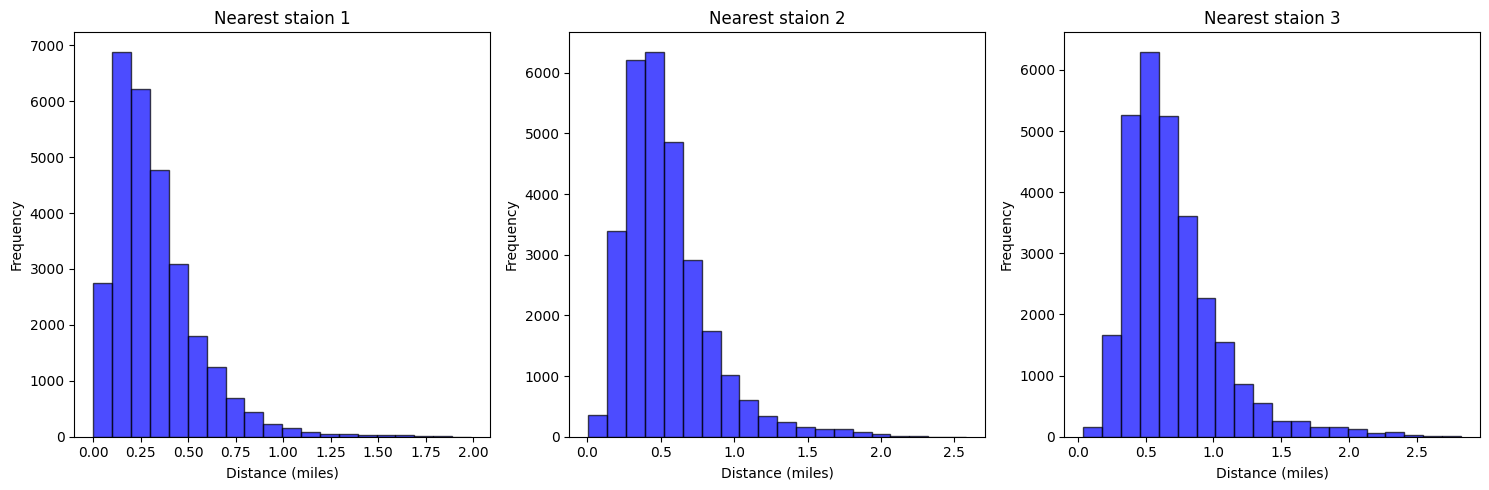

In [15]:
# Distributions to three nearest train/u-bahn stations for each data point 

distances_to_three_nearest = ["distance_to_station1",	"distance_to_station2",	"distance_to_station3"]	

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, column in enumerate(distances_to_three_nearest):
    axes[i].hist(gdf[column], bins=20, color='blue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f"Nearest staion {i+1}")
    axes[i].set_xlabel('Distance (miles)')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:
all_station_types = set(list(itertools.chain.from_iterable(gdf['station_type1'])))
print(all_station_types) # one hot encode for example ["NATIONAL_TRAIN",'LONDON_UNDERGROUND'] -> [1,0,0,1,0,0]

{'LONDON_OVERGROUND', 'TRAM', 'LONDON_UNDERGROUND', 'LIGHT_RAILWAY', 'NATIONAL_TRAIN', 'CABLE_CAR'}


# Spatial Vizualisations

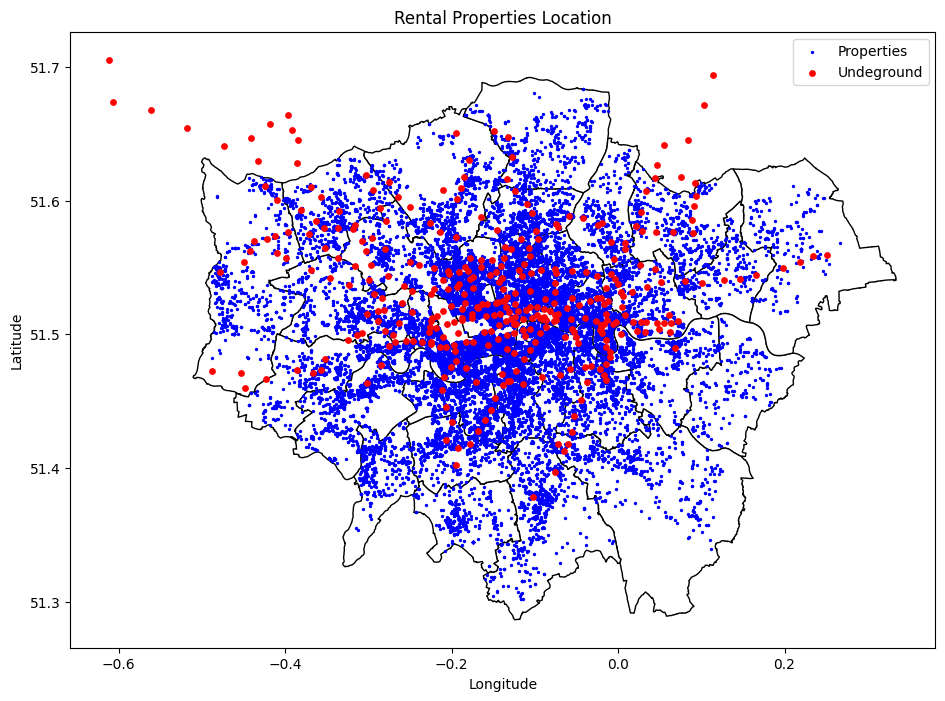

In [17]:
plt.figure(figsize=(12, 8))

london_boundaries.plot(ax=plt.gca(),  color='white', edgecolor='black')
gdf.plot(ax=plt.gca(), color='blue',markersize=2,label="Properties")
london_stations.plot(ax=plt.gca(), color='red',markersize=15, label="Undeground")

plt.title('Rental Properties Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.savefig("../images/map_check.png")
plt.show()

In [18]:
road_noize["NoiseClass"].value_counts()

NoiseClass
60.0-64.9    65921
55.0-59.9    65631
65.0-69.9    48657
70.0-74.9    12666
>=75.0        7299
Name: count, dtype: int64

In [19]:
road_noize

,NoiseClass,geometry
0,55.0-59.9,"POLYGON ((0.05411 51.29486, 0.05397 51.29487, ..."
1,55.0-59.9,"POLYGON ((0.05388 51.29613, 0.05388 51.29604, ..."
2,55.0-59.9,"POLYGON ((-0.14992 51.30024, -0.15002 51.30029..."
3,55.0-59.9,"POLYGON ((0.05398 51.29514, 0.05398 51.29505, ..."
4,55.0-59.9,"POLYGON ((-0.14992 51.30033, -0.14991 51.30051..."
...,...,...
200169,>=75.0,"POLYGON ((-0.11029 51.69133, -0.11044 51.69133..."
200170,>=75.0,"POLYGON ((-0.05234 51.68346, -0.05174 51.68345..."
200171,>=75.0,"POLYGON ((-0.02864 51.68235, -0.02864 51.68234..."
200172,>=75.0,"MULTIPOLYGON (((-0.24928 51.65518, -0.2493 51...."


In [21]:
gdf["geometry"]

id
154825190    POINT (-0.19944 51.47583)
155893427     POINT (-0.19348 51.4721)
154825184    POINT (-0.19944 51.47583)
154274906     POINT (-0.2063 51.46897)
152063288    POINT (-0.18516 51.47541)
                       ...            
156015842    POINT (-0.28784 51.55312)
152958695      POINT (-0.284 51.56469)
152955419    POINT (-0.28313 51.56414)
147232748    POINT (-0.29291 51.55398)
155503607    POINT (-0.27749 51.55735)
Name: geometry, Length: 28611, dtype: geometry

In [22]:
gdf['circle'] = gdf.geometry.buffer(300)

/tmp/ipykernel_7233/2310087957.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['circle'] = gdf.geometry.buffer(300)


In [23]:
gdf["circle"]

id
154825190    POLYGON ((299.80056 51.47583, 298.35598 22.070...
155893427    POLYGON ((299.80652 51.4721, 298.36194 22.0669...
154825184    POLYGON ((299.80056 51.47583, 298.35598 22.070...
154274906    POLYGON ((299.7937 51.46897, 298.34912 22.0638...
152063288    POLYGON ((299.81484 51.47541, 298.37026 22.070...
                                   ...                        
156015842    POLYGON ((299.71216 51.55312, 298.26758 22.147...
152958695    POLYGON ((299.716 51.56469, 298.27141 22.15955...
152955419    POLYGON ((299.71687 51.56414, 298.27229 22.159...
147232748    POLYGON ((299.70709 51.55398, 298.26251 22.148...
155503607    POLYGON ((299.72251 51.55735, 298.27793 22.152...
Name: circle, Length: 28611, dtype: geometry

In [27]:
road_noize.iloc[0]

NoiseClass                                            55.0-59.9
geometry      POLYGON ((0.0541148826840408 51.29486447775027...
Name: 0, dtype: object

1/4 mile distance and take maximum value

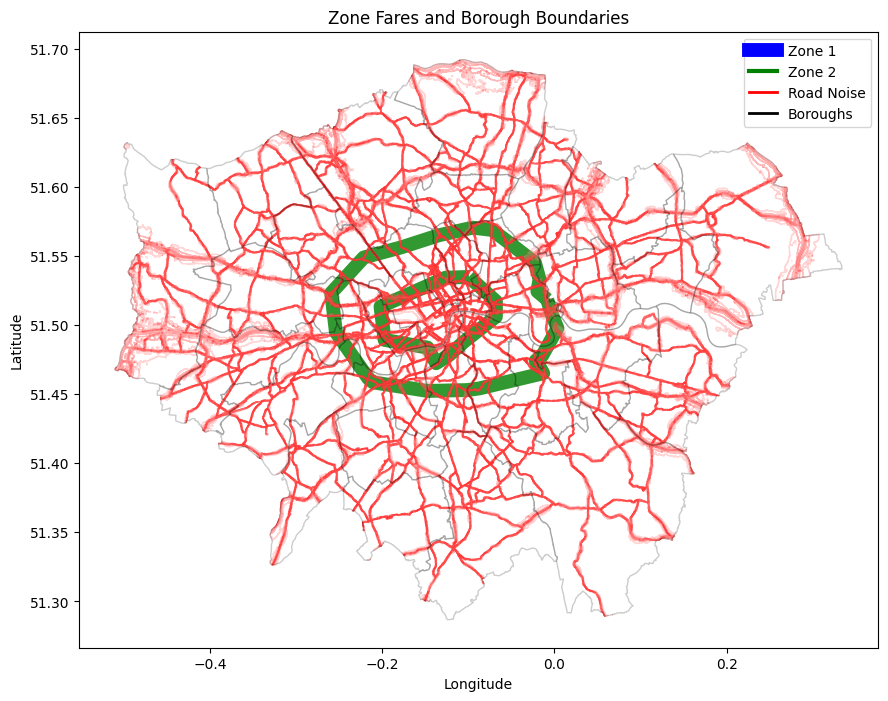

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

zone_fares[zone_fares["Name"] == "Zone 1"].plot(ax=ax, color='white', edgecolor='blue', linewidth=4)
zone_fares[zone_fares["Name"] == "Zone 2"].plot(ax=ax, color='white', edgecolor='green', linewidth=10)
road_noize.plot(ax=ax, color='white', edgecolor='red', alpha=0.2)

london_boundaries.plot(ax=ax, color='white', edgecolor='black', alpha=0.2)

ax.set_title('Zone Fares and Borough Boundaries')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

handles = [
    plt.Line2D([0], [0], color='blue', lw=10),  # Zone 1
    plt.Line2D([0], [0], color='green', lw=3),  # Zone 2
    plt.Line2D([0], [0], color='red', lw=2),    # Road Noise
    plt.Line2D([0], [0], color='black', lw=2)   # Boroughs
]
labels = ['Zone 1', 'Zone 2', 'Road Noise', 'Boroughs']
ax.legend(handles=handles, labels=labels)
plt.show()
